Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 50
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


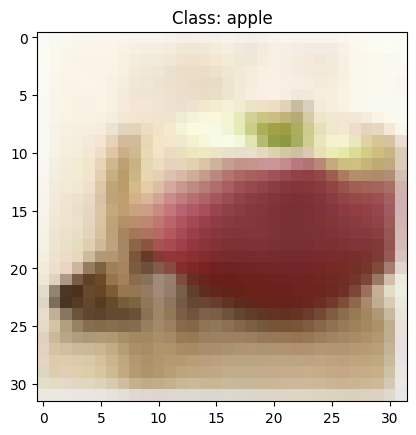

Sample input image class: boy


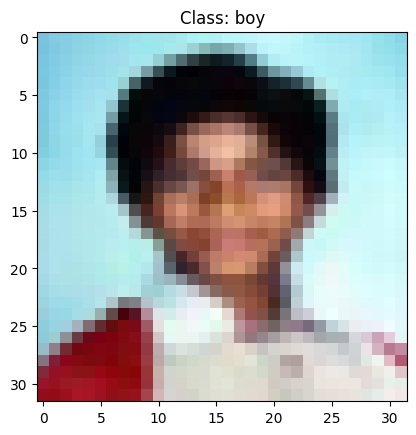

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)




x = conv_block(x, 64, stride=1)
x = identity_block(x, 64)

x = conv_block(x, 128, stride=2)
x = identity_block(x, 128)


x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:

OPTIM1 = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 695,588 (2.65 MB)

 Trainable params: 693,540 (2.65 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
    ]
)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0830 - loss: 4.1306
Epoch 1: val_accuracy improved from -inf to 0.00930, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 3.8171 - Training Accuracy: 0.1200
  Validation Loss: 6.5325 - Validation Accuracy: 0.0093
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.0833 - loss: 4.1286 - val_accuracy: 0.0093 - val_loss: 6.5325
Epoch 2/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2043 - loss: 3.2853
Epoch 2: val_accuracy improved from 0.00930 to 0.03640, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 3.1777 - Training Accuracy: 0.2237
  Validation Loss: 4.9554 - Validation Accuracy: 0.0364
! Overfitting: 0.1873 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2048 - loss: 3.2825 - val_accuracy: 0.0364 - val_loss: 4.9554
Epoch 3/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2731 - loss: 2.8940
Epoch 3: val_accuracy did not improve from 0.03640

Epoch 3
LR: 1.0e-03

  Training Loss: 2.8203 - Training Accuracy: 0.2877
  Validation Loss: 8.7159 - Validation Accuracy: 0.0357
! Overfitting: 0.2520 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2735 - loss: 2.8922 - val_accuracy: 0.0357 - val_loss: 8.7159
Epoch 4/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3310 - loss: 2.6152
Epoch 4: val_accuracy improved from 0.03640 to 0.21500, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.5615 - Training Accuracy: 0.3417
  Validation Loss: 3.3737 - Validation Accuracy: 0.2150
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3313 - loss: 2.6138 - val_accuracy: 0.2150 - val_loss: 3.3737
Epoch 5/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3774 - loss: 2.3809
Epoch 5: val_accuracy did not improve from 0.21500

Epoch 5
LR: 1.0e-03

  Training Loss: 2.3474 - Training Accuracy: 0.3846
  Validation Loss: 4.5197 - Validation Accuracy: 0.1508
! Overfitting: 0.2338 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3775 - loss: 2.3800 - val_accuracy: 0.1508 - val_loss: 4.5197
Epoch 6/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4170 - loss: 2.2060
Epoch 6: val_accuracy did not improve from 0.21500

Epoch 6
LR: 1.0e-03

  Training Loss: 2.1785 - Training Accuracy: 0.4220
  Validation Loss: 4.4248 - Validation Accuracy: 0.1557
! Overfitting: 0.2664 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - ac


Epoch 8
LR: 1.0e-03

  Training Loss: 1.9149 - Training Accuracy: 0.4817
  Validation Loss: 3.9391 - Validation Accuracy: 0.2158
! Overfitting: 0.2659 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4755 - loss: 1.9355 - val_accuracy: 0.2158 - val_loss: 3.9391
Epoch 9/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5076 - loss: 1.8192
Epoch 9: val_accuracy did not improve from 0.21580

Epoch 9
LR: 1.0e-03

  Training Loss: 1.8088 - Training Accuracy: 0.5060
  Validation Loss: 4.1449 - Validation Accuracy: 0.1792
! Overfitting: 0.3268 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5076 - loss: 1.8189 - val_accuracy: 0.1792 - val_loss: 4.1449
Epoch 10/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5219 - loss: 1.7333
Epoch 10: val_accuracy improved from 0.21580 to 0.29330, saving model to best_model.h5



Epoch 10
LR: 1.0e-03

  Training Loss: 1.7163 - Training Accuracy: 0.5263
  Validation Loss: 3.0116 - Validation Accuracy: 0.2933
! Overfitting: 0.2330 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5221 - loss: 1.7329 - val_accuracy: 0.2933 - val_loss: 3.0116
Epoch 11/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5490 - loss: 1.6346
Epoch 11: val_accuracy did not improve from 0.29330

Epoch 11
LR: 1.0e-03

  Training Loss: 1.6280 - Training Accuracy: 0.5478
  Validation Loss: 4.2712 - Validation Accuracy: 0.2034
! Overfitting: 0.3444 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5490 - loss: 1.6344 - val_accuracy: 0.2034 - val_loss: 4.2712
Epoch 12/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5720 - loss: 1.5426
Epoch 12: val_accuracy did not improve from 0.29330

Epoch 12
LR: 1.0e-03

  Training Loss: 1.5484 - Training Accuracy: 0.5683
  Validation Loss: 3.6650 - Validation Accuracy: 0.2474
! Overfitting: 0.3208 gap
157/157 ━━━━━


Epoch 14
LR: 1.0e-03

  Training Loss: 1.4036 - Training Accuracy: 0.6025
  Validation Loss: 3.1819 - Validation Accuracy: 0.3022
! Overfitting: 0.3003 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6054 - loss: 1.4030 - val_accuracy: 0.3022 - val_loss: 3.1819
Epoch 15/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6204 - loss: 1.3341
Epoch 15: val_accuracy did not improve from 0.30220

Epoch 15
LR: 1.0e-03

  Training Loss: 1.3382 - Training Accuracy: 0.6195
  Validation Loss: 3.6669 - Validation Accuracy: 0.2872
! Overfitting: 0.3323 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6204 - loss: 1.3342 - val_accuracy: 0.2872 - val_loss: 3.6669
Epoch 16/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6397 - loss: 1.2689
Epoch 16: val_accuracy did not improve from 0.30220

Epoch 16
LR: 1.0e-03

  Training Loss: 1.2718 - Training Accuracy: 0.6373
  Validation Loss: 5.9413 - Validation Accuracy: 0.1780
! Overfitting: 0.4593 gap
157/157 ━━━━━


Epoch 17
LR: 1.0e-03

  Training Loss: 1.2169 - Training Accuracy: 0.6516
  Validation Loss: 3.3054 - Validation Accuracy: 0.3380
! Overfitting: 0.3136 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6520 - loss: 1.2172 - val_accuracy: 0.3380 - val_loss: 3.3054
Epoch 18/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6689 - loss: 1.1423
Epoch 18: val_accuracy did not improve from 0.33800

Epoch 18
LR: 1.0e-03

  Training Loss: 1.1557 - Training Accuracy: 0.6674
  Validation Loss: 3.7912 - Validation Accuracy: 0.2603
! Overfitting: 0.4071 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6689 - loss: 1.1427 - val_accuracy: 0.2603 - val_loss: 3.7912
Epoch 19/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6855 - loss: 1.0891
Epoch 19: val_accuracy did not improve from 0.33800

Epoch 19
LR: 1.0e-03

  Training Loss: 1.1010 - Training Accuracy: 0.6813
  Validation Loss: 4.3934 - Validation Accuracy: 0.2841
! Overfitting: 0.3972 gap
157/157 ━━━━━


Epoch 21
LR: 1.0e-03

  Training Loss: 0.9878 - Training Accuracy: 0.7146
  Validation Loss: 2.9857 - Validation Accuracy: 0.3434
! Overfitting: 0.3712 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7195 - loss: 0.9711 - val_accuracy: 0.3434 - val_loss: 2.9857
Epoch 22/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7334 - loss: 0.9214
Epoch 22: val_accuracy improved from 0.34340 to 0.36910, saving model to best_model.h5



Epoch 22
LR: 1.0e-03

  Training Loss: 0.9388 - Training Accuracy: 0.7272
  Validation Loss: 3.0285 - Validation Accuracy: 0.3691
! Overfitting: 0.3581 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7333 - loss: 0.9219 - val_accuracy: 0.3691 - val_loss: 3.0285
Epoch 23/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7448 - loss: 0.8737
Epoch 23: val_accuracy did not improve from 0.36910

Epoch 23
LR: 1.0e-03

  Training Loss: 0.8861 - Training Accuracy: 0.7421
  Validation Loss: 3.0032 - Validation Accuracy: 0.3592
! Overfitting: 0.3829 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7447 - loss: 0.8740 - val_accuracy: 0.3592 - val_loss: 3.0032
Epoch 24/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7589 - loss: 0.8151
Epoch 24: val_accuracy did not improve from 0.36910

Epoch 24
LR: 1.0e-03

  Training Loss: 0.8394 - Training Accuracy: 0.7516
  Validation Loss: 2.8035 - Validation Accuracy: 0.3503
! Overfitting: 0.4013 gap
157/157 ━━━━━


Epoch 26
LR: 1.0e-03

  Training Loss: 0.7425 - Training Accuracy: 0.7821
  Validation Loss: 2.7426 - Validation Accuracy: 0.3873
! Overfitting: 0.3947 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7893 - loss: 0.7267 - val_accuracy: 0.3873 - val_loss: 2.7426
Epoch 27/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8062 - loss: 0.6599
Epoch 27: val_accuracy improved from 0.38730 to 0.42920, saving model to best_model.h5



Epoch 27
LR: 1.0e-03

  Training Loss: 0.6879 - Training Accuracy: 0.7961
  Validation Loss: 2.4308 - Validation Accuracy: 0.4292
! Overfitting: 0.3669 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8059 - loss: 0.6606 - val_accuracy: 0.4292 - val_loss: 2.4308
Epoch 28/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8198 - loss: 0.6286
Epoch 28: val_accuracy did not improve from 0.42920

Epoch 28
LR: 1.0e-03

  Training Loss: 0.6397 - Training Accuracy: 0.8139
  Validation Loss: 3.7258 - Validation Accuracy: 0.3054
! Overfitting: 0.5085 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8196 - loss: 0.6289 - val_accuracy: 0.3054 - val_loss: 3.7258
Epoch 29/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8307 - loss: 0.5792
Epoch 29: val_accuracy did not improve from 0.42920

Epoch 29
LR: 1.0e-03

  Training Loss: 0.6023 - Training Accuracy: 0.8226
  Validation Loss: 4.7585 - Validation Accuracy: 0.2954
! Overfitting: 0.5272 gap
157/157 ━━━━━

In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


## Evaluation

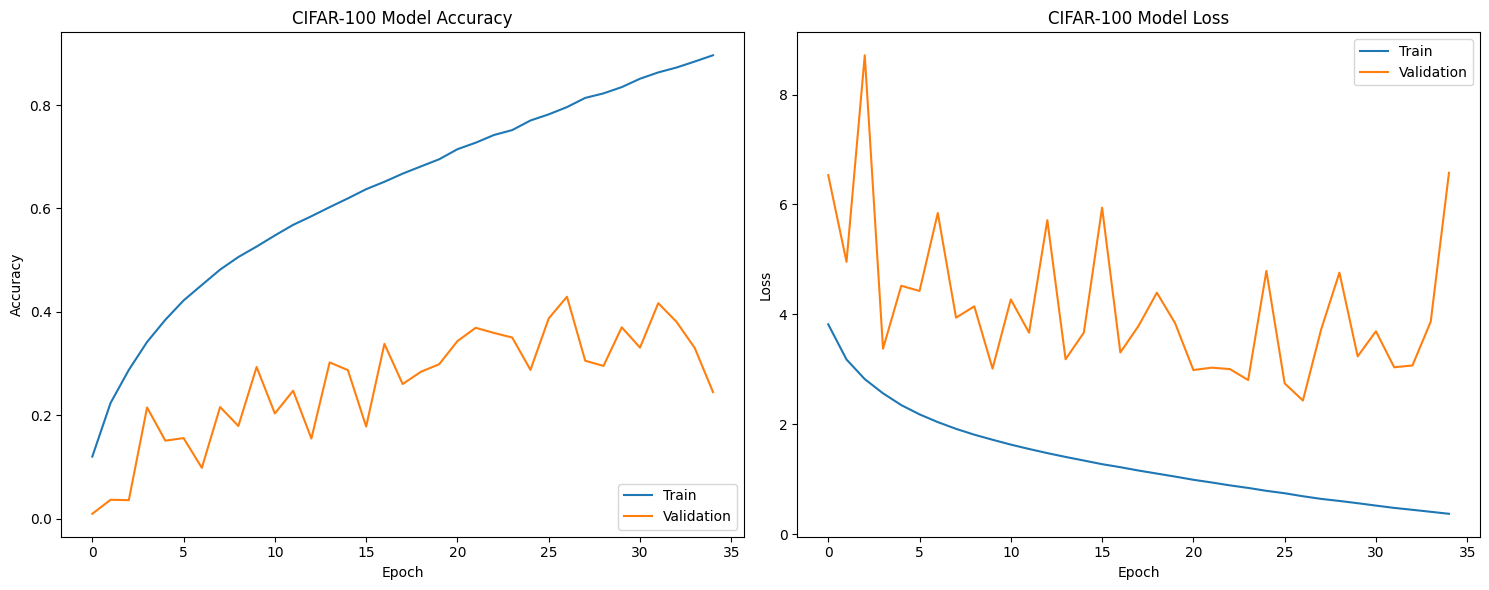

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4387 - loss: 2.3991

Test Loss: 2.4110
Test Accuracy: 0.4352
